In [13]:
from pytorch_grad_cam import GradCAM
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.models import ResNet18_Weights
import torch.nn.functional as F

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import os
import random
from PIL import Image
import numpy as np
import copy

In [2]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [3]:
model = torchvision.models.__dict__['resnet18'](weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model = nn.DataParallel(model, [0,1])
model.cuda()

checkpoint = torch.load("attack_models/model_95.pth", map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
folder = "../dataset/train/nsfw/"
num_images = 8
imgs_list = os.listdir(folder)
imgs_list = random.sample(imgs_list, num_images)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

inverse_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize])

In [148]:
input_tensors = []
original_imgs = []
with torch.no_grad():
    for img_name in imgs_list:
        img_name = os.path.join(folder, img_name)
        img = Image.open(img_name).convert('RGB')
        # img = transform(img)
        # img = img.unsqueeze(0).cuda()

        # cp_img = copy.deepcopy(img)
        img = img.resize((224, 224))
        original_img = copy.deepcopy(img)

        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        
        # original_img = copy.deepcopy(img)
        original_imgs.append(img)

        # cp_img = transform(cp_img)
        # cp_img = cp_img.unsqueeze(0)
        original_img = torchvision.transforms.functional.to_tensor(original_img).unsqueeze(0).float()
        input_tensors.append(original_img)

        # orig_img = copy.deepcopy(img)
        # orig_img = orig_img.squeeze(0)
        # orig_img = inverse_normalize(orig_img)
        # orig_img = transforms.ToPILImage()(orig_img)
        # orig_img = (orig_img - np.min(orig_img)) / (np.max(orig_img) - np.min(orig_img))
        # original_imgs.append(orig_img)

        # output = model(img)
        # y_pred = torch.round(torch.sigmoid(output))
        # y_pred = y_pred.cpu().numpy()[0][0]
        # print("Image - {} : {}".format(img_name, y_pred))

In [149]:
target_layers = [model.module.layer4[-2]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
targets = [ClassifierOutputTarget(0)]
# print(input_tensors[2].shape)
grayscale_cam = cam(input_tensor=input_tensors[2], targets=targets)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(original_imgs[2], grayscale_cam, use_rgb=True)

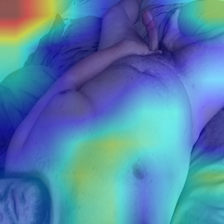

In [150]:
Image.fromarray(visualization, 'RGB')